In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.sparse as sparse

from sklearn.model_selection import train_test_split

import tensorflow as tf

import os

import skimage.io
from skimage import morphology

# Character Recognition

## Introduction

OCR is becoming a very commonly used tool. Nowadays you can find it in almost every phone even. And the premise of it is kind of scary - a machine is reading text from an image, something that only us humans could do. You could say that computers are starting to rival us in other fields also, drawing for example, there are some image generating models that make exceptional pictures. It is crazy how just clusters of circuits are beating humans at what they were thought of to be the best in - cognitive thinking and creativity. This intriguing thought made me choose this topic when I was researching what to do my project on. (But I guess it would be much better if we did not look at AI as a rival but rather a tool used to automate tasks and make our lives easier, just saying.)

(P.S. Very dramatic intro, I know)

## Data handling

### Loading in the data

So for the purpose of this project we are going to use 2 datasets - one for digit and the other for letter recognition (only capital latin letters). For the digits we will be using the infamous MNIST dataset (for some reason it is not the usual MNIST dataset but a shortened version which contains only 42,000 images and not 70,000, however it should still do the trick... P.S. I know there is a redy-to-use version you can load directly from Tensorflow but that is no fun :)). As for the letters we will be using a similar dataset containing images of, you guessed it, letters. Both datasets are from the NIST database so you can tell they are quite alike. They contain numerous labeled 28x28 grayscale images.

Disclaimer: Reading the datasets might take some time :/

In [3]:
mnist = pd.read_csv('data/mnist/mnist.csv')
mnist

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
alphabet = pd.read_csv('data/alphabet/A_Z Handwritten Data.csv')
alphabet

,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,...,0.639,0.640,0.641,0.642,0.643,0.644,0.645,0.646,0.647,0.648
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372445,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372446,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372447,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
372448,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Formatting the data

We can see the first column represents the label of the image (letters are numbered from 0-25) and the rest is the actual 28x28 image in a 1D array.

Since the datasets are very similar, we are going to write a formatting function that will transform them both:

In [5]:
def format_df(dataframe):
    dataframe_labels = dataframe[dataframe.columns[0]]
    dataframe = dataframe.drop(columns=[dataframe.columns[0]])
    # separating the images from the labels
    
    result_df = pd.DataFrame(dataframe_labels)
    result_df.columns = ['label']
    # creating the dataframe the function will return out of the labels
    
    arr = sparse.coo_matrix(dataframe.to_numpy(), shape=dataframe.shape)
    result_df['image'] = arr.toarray().tolist()
    # adding the images to the result dataframe
    
    result_df.image = result_df.image.map(lambda x: np.array(x).astype('int32').reshape(28, 28))
    # reshaping the images so that they are 28x28
    
    return result_df[['image', 'label']]

Sweet! Now we can go ahead and apply it!

In [6]:
mnist = format_df(mnist)
mnist

,image,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
...,...,...
41995,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
41996,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
41997,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",7
41998,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",6


In [7]:
alphabet = format_df(alphabet)
alphabet

,image,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
...,...,...
372445,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",25
372446,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",25
372447,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",25
372448,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",25


Just to check the shapes of the images (should be (28, 28)):

In [8]:
print(mnist.iloc[0].image.shape)
print(alphabet.iloc[0].image.shape)

(28, 28)
(28, 28)


Ok, we can even show one image and its respective label from each dataset, just so that we are familiar with what we are working with:

The image below is labeled as: 7


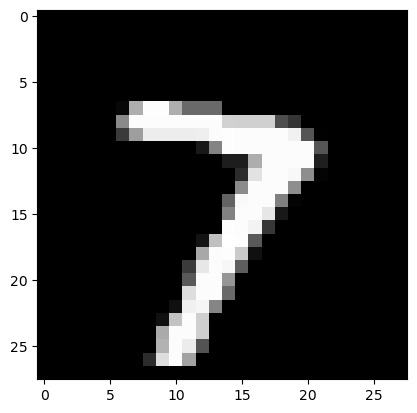

The image below is labeled as: B


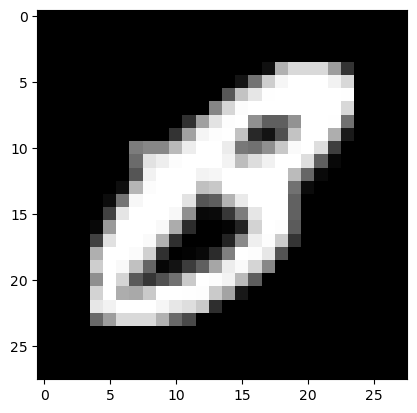

In [9]:
print(f'The image below is labeled as: {mnist.iloc[872].label}')
plt.imshow(mnist.iloc[872].image, cmap = 'gray')
plt.show()

print(f'The image below is labeled as: {chr(alphabet.iloc[18231].label + 65)}')
plt.imshow(alphabet.iloc[18231].image,cmap = 'gray')
plt.show()

So far, so good! There are only two things left to do - normalize the images for the sake of our model and concatinate the two dataframes to get one big dataframe which we are then going to split into training and testing samples.

We are going to normalize the data first but truly does not matter.

In [10]:
def normalize_imgs(dataframe):
    dataframe.image = dataframe.image.map(lambda x: x / 255)
    return dataframe

In [11]:
mnist = normalize_imgs(mnist)
alphabet = normalize_imgs(alphabet)

Now we shall concatinate them, but first since the letters from A to J are labeled as numbers from 0-9 and therefore the labels will overlap with these of the numbers, so we should add 10 to the labels of the letters. That would mean that the labels in our newly-formed dataset would mean 0-9 -> 0-9 and 10-35 -> A-Z:

In [12]:
alphabet.label = pd.Series(map(lambda x: x + 10, alphabet.label))

In [13]:
characters = pd.concat([mnist, alphabet], axis=0)
characters

,image,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",4
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
...,...,...
372445,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",35
372446,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",35
372447,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",35
372448,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",35


### Getting acquainted with the data

Ok, before we split the data into training and testing samples we can explore it a little bit further just so we know what to expect from our model.

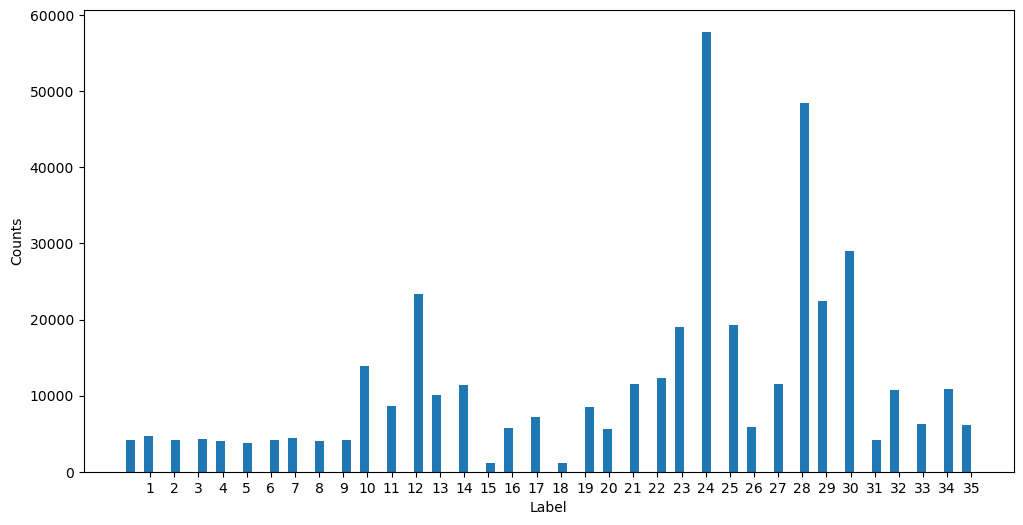

In [14]:
plt.figure(figsize=(12, 6))

plt.hist(characters.label, bins = 'fd')
plt.xticks(range(1,36))
plt.xlabel('Label')
plt.ylabel('Counts')
plt.show()

Hmh...

This predicament that we are in is an interesting one. The number of digit images is quite evenly distributed which is good, but that is not the case when it comes to the alphabet. There are cases where there is barely any of some letters. I guess you could argue that some letters are more common than others overall and a bias towards the more likely character could be helpful in some situations, but our model will surely have a hard time identifying some characters. Another thing that is not helpful is how many of some letters we have. Look at O for example (labeled as 24). In a tricky situation where a symbol looks like something between an O and a 0, our model may be biased towards O.

Now that we have identified some potential problems, how do we fix them?

... I dunno :)

I guess you could try to remove some of the entries in the dataframe, or find more appropriate datasets from the start, but I am kind of on a timer to hand this project in so we shall continue on with what we have now (it is not like it won't work, calm down).

## Creating the model

### Splitting the data

We shall start by first splitting the dataframe into a training and a testing sample:

In [15]:
train, test = train_test_split(characters, test_size=0.2)

In [16]:
print(train.shape)
print(test.shape)

(331560, 2)
(82890, 2)


Everything seems ready! All that is left is to fit the model!

### Training the model

*Sign*... I'm sorry in advance. (LOL, sounds very dramatic)

What follows is a mishmash of several youtube tutorials and a lot of trial and error from my side. The way this model has been constructed is definitely not optimal but it has been tweeked to the point it just works.

So, where were we? yep, training the model. OK! Let's first create one and add some layers to it (don't ask):

In [17]:
model = tf.keras.models.Sequential()

In [18]:
model.add(tf.keras.layers.Flatten(input_shape = (28,28)))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(512, activation='relu'))
model.add(tf.keras.layers.Dense(36, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Now to fit the model:

In [19]:
model.fit(np.array([*train.image]), np.array([*train.label]).astype('int32'), epochs=3)

Epoch 1/3
10362/10362 [==============================] - 68s 7ms/step - loss: 0.2737 - accuracy: 0.9239
Epoch 2/3
10362/10362 [==============================] - 65s 6ms/step - loss: 0.1497 - accuracy: 0.9595
Epoch 3/3
10362/10362 [==============================] - 65s 6ms/step - loss: 0.1242 - accuracy: 0.9666


### Final touches

When the model is finished training, it will be ready to be tested.

In [20]:
loss, accuracy = model.evaluate(np.array([*test.image]), np.array(test.label).astype('int32'))

print(f'The accuracy of this model is: {accuracy}')

2591/2591 [==============================] - 7s 3ms/step - loss: 0.1455 - accuracy: 0.9640
The accuracy of this model is: 0.9639642834663391


Ok, cool! Now that we have a working model we can do one last thing - a wrapper for its predict function in the name of convenience:

In [21]:
def give_prediction(img):
    prediction = np.argmax(model.predict(img.reshape(-1, 28, 28)))
    if prediction > 9:
        return chr(prediction + 55)
    else:
        return prediction

## Experimenting

### Is image morphology effective?

As we saw our model supposedly does pretty well with the images it is given, judging by the accuracy test above. I guess that begs the question if we can give it better images, or rather put a filter before an image is given to the model. Would image morphology help in accomplishing such a task? I guess we will find out.

We are going to carry out 4 evaluations of the model over the testing data but each time the data will be affected by different morphological operations - erosion, dilation, opening and closing.

In [22]:
sq = morphology.square(width=3)

In [23]:
erosion_loss, erosion_accuracy = model.evaluate(np.array([*test.image.map(lambda x: morphology.erosion(x, sq))]), np.array(test.label).astype('int32'))
dilation_loss, dilation_accuracy = model.evaluate(np.array([*test.image.map(lambda x: morphology.dilation(x, sq))]), np.array(test.label).astype('int32'))
opening_loss, opening_accuracy = model.evaluate(np.array([*test.image.map(lambda x: morphology.opening(x, sq))]), np.array(test.label).astype('int32'))
closing_loss, closing_accuracy = model.evaluate(np.array([*test.image.map(lambda x: morphology.closing(x, sq))]), np.array(test.label).astype('int32'))

2591/2591 [==============================] - 7s 3ms/step - loss: 0.2042 - accuracy: 0.9506


Now we can compare which scenario is best:

In [24]:
print(f'Normal images prediction accuracy: {accuracy}')
print(f'Eroded images prediction accuracy: {erosion_accuracy}')
print(f'Dilated images prediction accuracy: {dilation_accuracy}')
print(f'Opened images prediction accuracy: {opening_accuracy}')
print(f'Closed images prediction accuracy: {closing_accuracy}') # "Opened images" and "Closed images" sound stupid btw

Normal images prediction accuracy: 0.9639642834663391
Eroded images prediction accuracy: 0.6109904646873474
Dilated images prediction accuracy: 0.33858126401901245
Opened images prediction accuracy: 0.7923392653465271
Closed images prediction accuracy: 0.950560986995697


I guess we could also plot them and see how they compare visually:

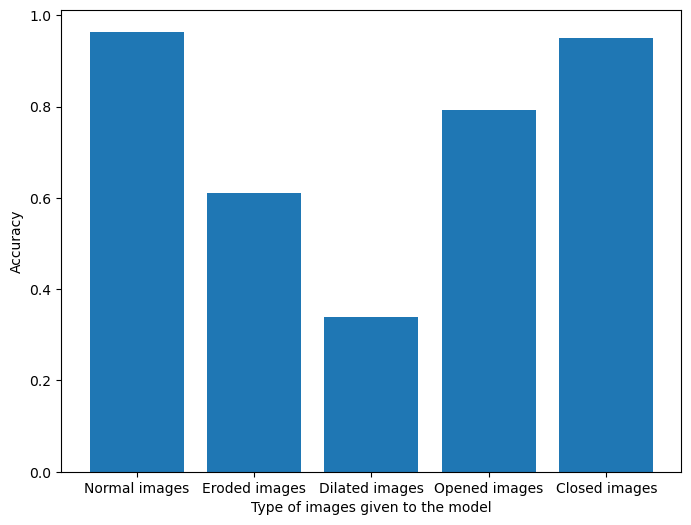

In [25]:
plt.figure(figsize=(8, 6))

plt.bar(['Normal images', 'Eroded images', 'Dilated images', 'Opened images', 'Closed images'],
        [accuracy, erosion_accuracy, dilation_accuracy, opening_accuracy, closing_accuracy])
plt.xlabel('Type of images given to the model')
plt.ylabel('Accuracy')
plt.show()

I guess it is no surprise the model is most accurate with the same type of data it was trained with (although the images with the closing morphology are a close runner-up). Maybe we should have trained our model with 'better' images and then we could expect it to work efficiently with them.

### Guessing my characters

I do not know about you but now I'm itching to see our model in action. For this purpose, I have drawn some very beatiful images and saved them in `/data/trial`. We are going to go through them and see how our character recognition model works.

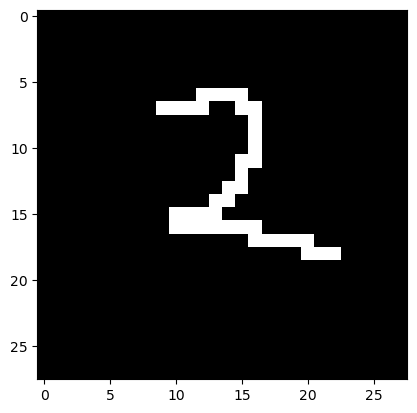

1/1 [==============================] - 0s 122ms/step
Prediction: 3


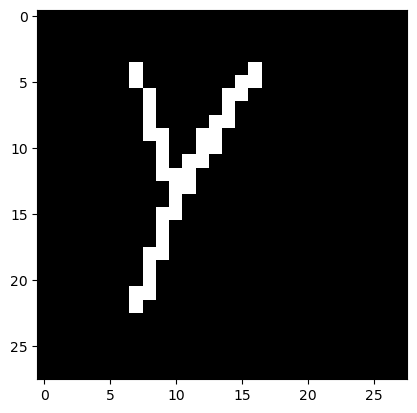

1/1 [==============================] - 0s 19ms/step
Prediction: Y


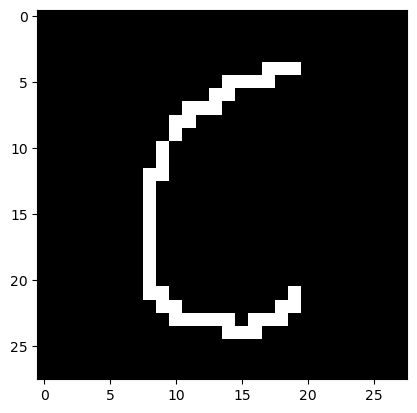

1/1 [==============================] - 0s 17ms/step
Prediction: C


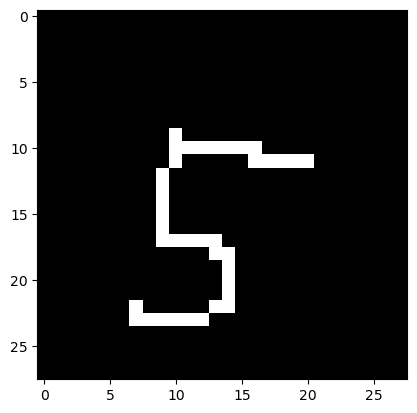

1/1 [==============================] - 0s 18ms/step
Prediction: S


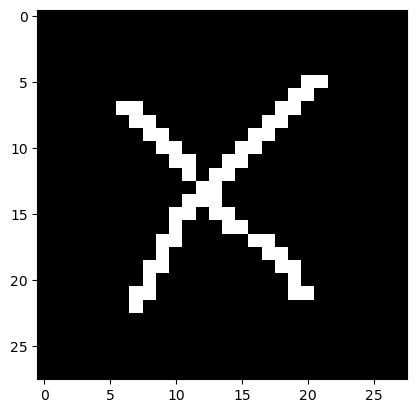

1/1 [==============================] - 0s 18ms/step
Prediction: X


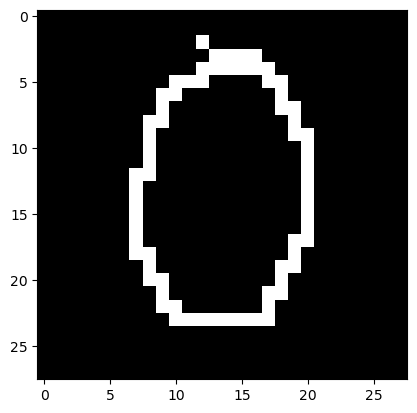

1/1 [==============================] - 0s 18ms/step
Prediction: 0


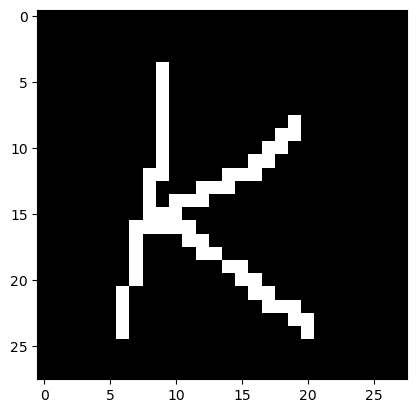

1/1 [==============================] - 0s 17ms/step
Prediction: K


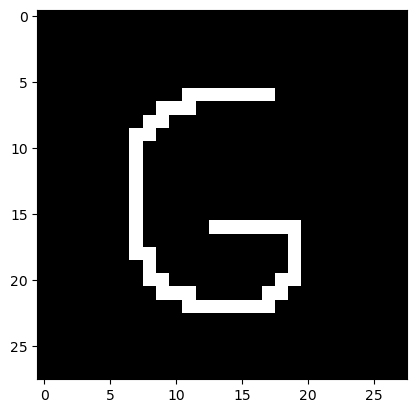

1/1 [==============================] - 0s 19ms/step
Prediction: G


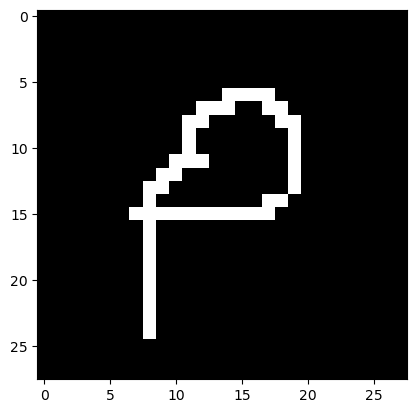

1/1 [==============================] - 0s 17ms/step
Prediction: P


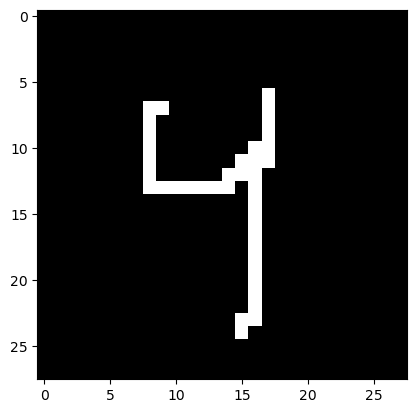

1/1 [==============================] - 0s 19ms/step
Prediction: 4


In [26]:
image_number = 1

while os.path.isfile(f'data/trial/trial{image_number}.png'): 
    img = skimage.io.imread(f'data/trial/trial{image_number}.png') # reading the image from the file
    img = np.invert(np.average(img, axis=-1).astype('uint8')) # getting the image ready to be processed (shoutout to the lab)
    plt.imshow(img, cmap = 'gray')
    plt.show()
    print(f'Prediction: {give_prediction(img)}')
    image_number += 1

It somewhat works. It must be that my drawings are very ugly because I personally do not know where the accuracy from before went. And to be fair there is a difference, so, unfortunately, in real circumstances our model wil not be as accurate as the test we ran before. :(

## Sources / Credits

1. Datasets
    * [Digit Dataset](https://www.kaggle.com/datasets/dillsunnyb11/digit-recognizer?resource=download&select=test.csv)
    * [Letter Dataset](https://www.kaggle.com/datasets/sachinpatel21/az-handwritten-alphabets-in-csv-format?select=A_Z+Handwritten+Data.csv)
2. [NeuralNine](https://www.youtube.com/watch?v=bte8Er0QhDg&t=348s)
3. [Nicholas Renotte](https://www.youtube.com/watch?v=jztwpsIzEGc)